In [ ]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [1]:
import PySimpleGUI as sg    
from pykat import finesse
from pykat.commands import * 
import pykat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import math

sg.theme('Default1')

def collapse(layout, key):
    """
    Helper function that creates a Column that can be later made hidden, thus appearing "collapsed"
    :param layout: The layout for the section
    :param key: Key used to make this seciton visible / invisible
    :return: A pinned column that can be placed directly into your layout
    :rtype: sg.pin
    """
    return sg.pin(sg.Column(layout, key=key))

..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# isscan = 
# isdemod_once =

In [3]:
def generate_kat_FPMI(dic_ispds, dic_advanced_setting):

    ###############################
    ### get variables from GUI ###
    
    ### Optic ###
    laser_power = dic_advanced_setting["laser_power"]#source laser power
    
    ### DoF ###
    #
    # (yuzu) pick up DoF (CARM / DARM / BS) from GUI
    # 
    dof = dic_advanced_setting["dof"]#CARM DARM BS
    
    #################################################################################
    ### sweep_power/sweep_demod_1/transferfunction_power/transferfunction_demod_2 ###
    #################################################################################
    type_of_pd_signal = dic_advanced_setting["type_of_pd_signal"]#(sweep_mode)

    ###########################
    ### xaxis/yaxis setting ###
    ###########################
    x_plotscale = dic_advanced_setting["x_plotscale"]#str
    xaxis_range_beg = dic_advanced_setting["xaxis_range_beg"]#str
    xaxis_range_end = dic_advanced_setting["xaxis_range_end"]#str
    y_plotscale = dic_advanced_setting["y_plotscale"]#str
    if x_plotscale=='linear':
        x_plotscale = 'lin'
    if y_plotscale=='linear':
        y_plotscale = 'lin'
    #yaxis_range_beg = dic_advanced_setting["yaxis_range_beg"]
    #yaxis_range_end = dic_advanced_setting["yaxis_range_end"]
    samplingnum = dic_advanced_setting["samplingnum"]

    #################################################
    ### pd1 advanced setting/pd2 advanced setting ###
    #################################################
    pd1_demod_phase = dic_advanced_setting["pd1_demod_phase"]#str
    pd1_demodfreq = dic_advanced_setting["pd1_demodfreq"]#str
    pd2_demod_phase = dic_advanced_setting["pd2_demod_phase"]#str
    pd2_mixer1_demodfreq = dic_advanced_setting["pd2_mixer1_demodfreq"]#str
    # default demod_phase, demod_freque is Pd1's configuration
    demod_phase = dic_advanced_setting["pd1_demod_phase"]#str
    demod_freq = dic_advanced_setting["pd1_demodfreq"]#str
    if(type_of_pd_signal=="transferfunction_demod_2"):
        demod_phase  = dic_advanced_setting["pd2_demod_phase"]#str
        demod_freq = dic_advanced_setting["pd2_mixer1_demodfreq"]#str
    # demod_phase_I,demod_phase_Q must define after demod_phase is defined
    demod_phase_I = str(0+float(demod_phase))#str
    demod_phase_Q = str(90+float(demod_phase))#str

    
    ###############################
    ### INF components ###
    #
    # Prepare common (fixed for KAGRA) setting for kat file 
    # 
    input_finesse = """
    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nxtrans

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nytrans

    """ % (laser_power)

    ### PDs location ###
    
    # demod_num
    # demod_phase #slider?
    pd0s_code = ""
    pd1s_code = ""
    pd2s_code = ""

    for key in dic_ispds.keys():
        if dic_ispds[key] == True:
            if(type_of_pd_signal=="sweep_power" or type_of_pd_signal=="transferfunction_power"):
                pd0s_code_add = """
pd0 pd0_%s %s
                """% (key,key,
                    )
                input_finesse = input_finesse + pd0s_code_add # input finesse ni tyokusetu tasu
 # pd(n) node IorQ frequency
            if(type_of_pd_signal=="sweep_demod_1"):
                pd1s_code_add = """
pd1 pd1_I1_%s $f1_SB %s %s
pd1 pd1_Q1_%s $f1_SB %s %s
pd1 pd1_I2_%s $f2_SB %s %s
pd1 pd1_Q2_%s $f2_SB %s %s
pd1 pd1_IX_%s %s %s %s
pd1 pd1_QX_%s %s %s %s
                """% (key, demod_phase_I, key,
                    key, demod_phase_Q, key,
                    key, demod_phase_I, key,
                    key, demod_phase_Q, key,
                    key, demod_freq, demod_phase_I, key,
                    key, demod_freq, demod_phase_Q, key
                    )
                input_finesse = input_finesse + pd1s_code_add
            if(type_of_pd_signal=="transferfunction_demod_2"):
                pd2s_code_add ="""
pd2 pd2_I1_%s $f1_SB %s 10 %s
put pd2_I1_%s f2 $x1
pd2 pd2_Q1_%s $f1_SB %s 10 %s
put pd2_Q1_%s f2 $x1

pd2 pd2_I2_%s $f2_SB %s 10 %s
put pd2_I2_%s f2 $x1
pd2 pd2_Q2_%s $f2_SB %s 10 %s
put pd2_Q2_%s f2 $x1

pd2 pd2_IX_%s %s %s 10 %s
put pd2_IX_%s f2 $x1
pd2 pd2_QX_%s %s %s 10 %s
put pd2_QX_%s f2 $x1
                """% (key, demod_phase_I, key,
                    key,
                    key, demod_phase_Q, key,
                    key,
                    key, demod_phase_I, key,
                    key,
                    key, demod_phase_Q, key,
                    key,
                    key, demod_freq, demod_phase_I, key,
                    key,
                    key, demod_freq, demod_phase_Q, key,
                    key
                    )
                input_finesse = input_finesse + pd2s_code_add

    #+pd2s_code
    
    if(type_of_pd_signal=="transferfunction_power" or type_of_pd_signal=="transferfunction_demod_2"):
        
        ### DoF ###
        if(dof=="DARM"):
            darm_sweep = """
## DARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
## CARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
## BS ###
fsig sig1 ETMX 10 0
fsig sig1 ITMX 10 0
fsig sig1 ETMY 10 180
fsig sig1 ITMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass
    if(type_of_pd_signal=="sweep_power" or type_of_pd_signal=="sweep_demod_1"):
      
        ### DoF ###

        if(dof=="DARM"):
            darm_sweep = """
# DARM scan
xaxis ETMX phi %s %s %s %s
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + darm_sweep

        elif(dof=="CARM"):
            carm_sweep = """
# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi %s %s %s %s
put* ETMY phi $x1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + carm_sweep

        elif(dof=="BS"):
            bs_sweep = """
# BS scan
#
#(koyama) original vergion og kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi %s %s %s %s
put* ITMY phi $mx1
put* ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
            input_finesse = input_finesse + bs_sweep
        else:
            pass

    code = input_finesse
    print(code)
    return code

In [4]:
#　保存されるときの名前が勝手に固有の名前が生成される
# DARM FPMI laserpower タイトルでどの設定かわかる名前
# 画像の保存のチェックボックス
# 保存場所がどこかポップアップで表示


    
### FPMI

const f1_SB 16.881M
const f2_SB 45.0159M

# Input optics
l i1 1 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nxtrans

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nytrans

    
pd0 pd0_REFL REFL
                
pd0 pd0_AS AS
                
pd0 pd0_nytrans nytrans
                
pd0 pd0_nxtrans nxtrans
                
# DARM scan
xaxis ETMX phi lin -180 180 500
put* ETMY phi $mx1
yaxis abs
            
--------------------------------------------------------------
Running kat - Started at 2020-08-30 00:23:13.316971
Used Finesse 2.3.1 at /Users/koyamanaoki/opt/anaconda3/envs/finesse/bin/kat

Finished in 0.0550127 seconds
100% | ETA:  0:00:00 | Calculating

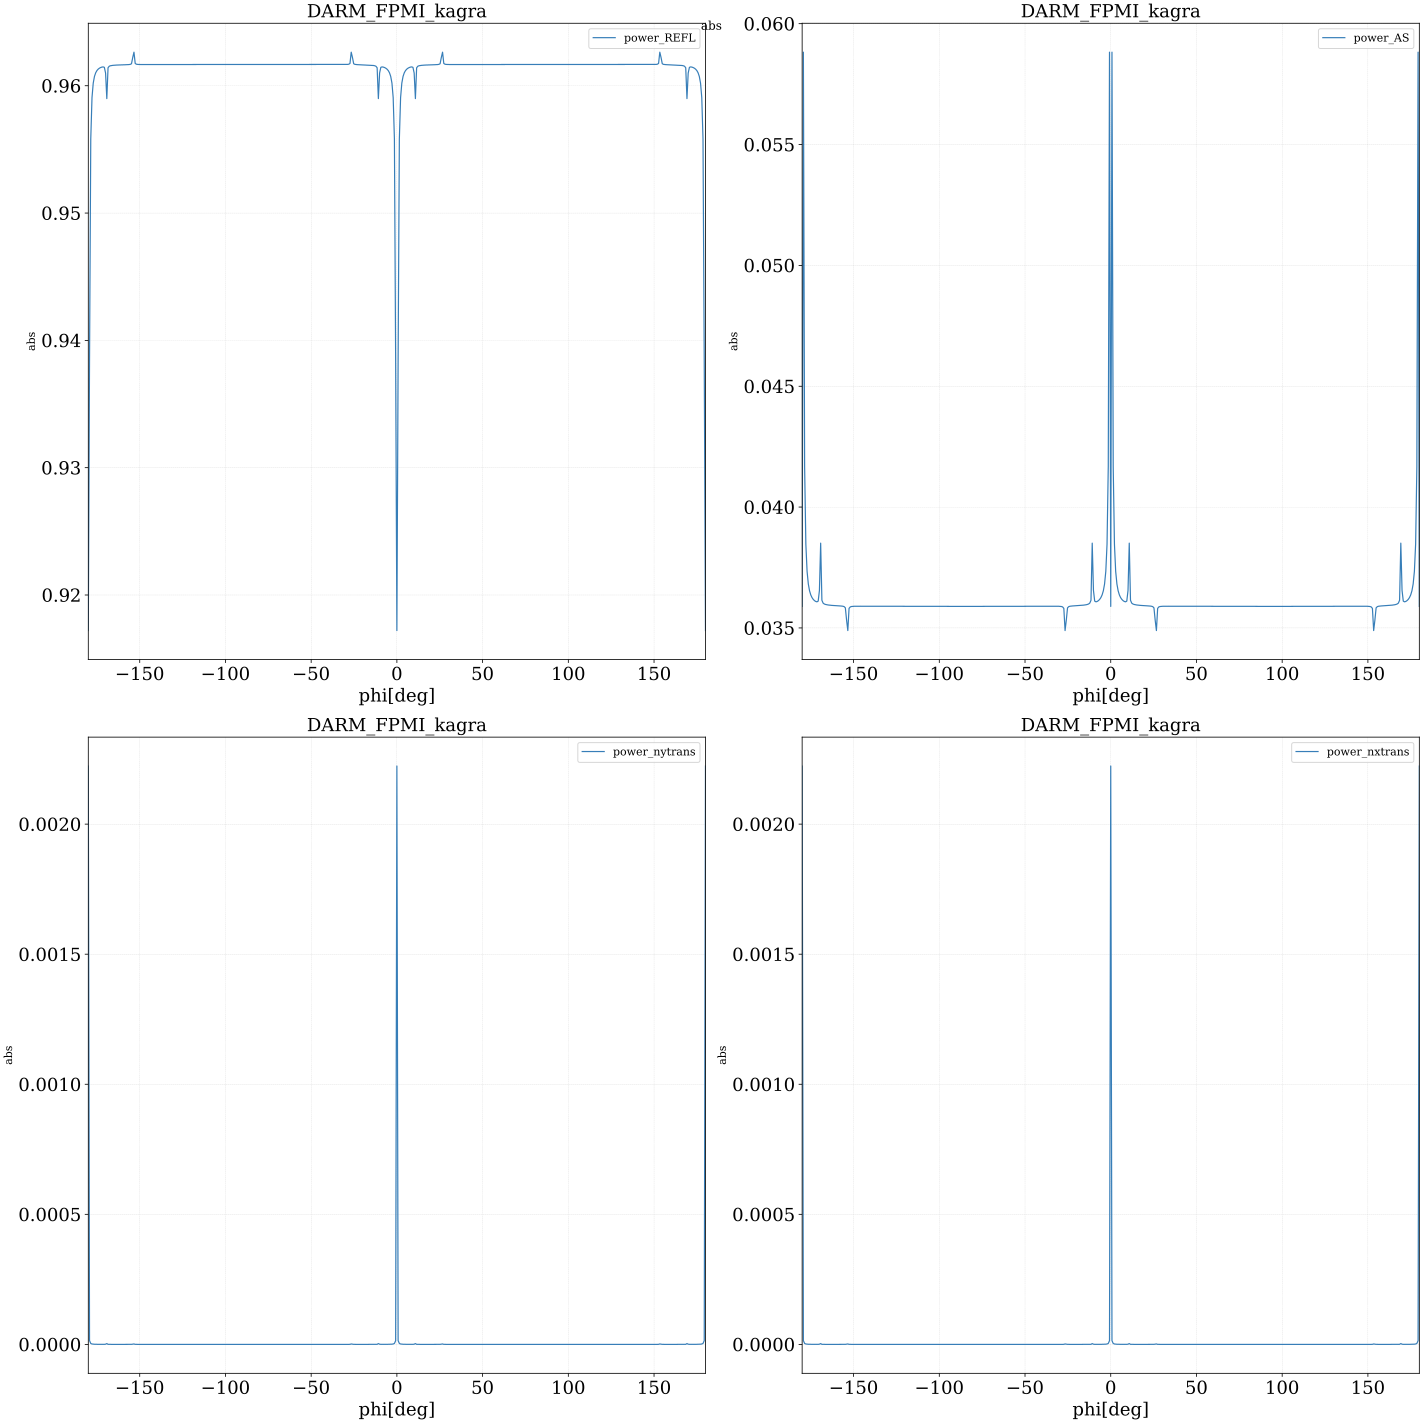

In [5]:
##################################    
#section setting pd0/pd1/pd2
##################################
fpmi_section_pd0 = [

            ]
fpmi_section_pd1 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='pd1_I1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(20, 1), key='pd1_Q1'),
            sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), key='pd1_plot_I_Q_overplot_f1'),
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='pd1_I2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(20, 1), key='pd1_Q2'),
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='pd1_plot_I_Q_overplot_f2')],
            [sg.Text('Demodulation_frequency'),sg.Input(key='pd1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='pd1_demod_phase', default_text='0', enable_events=True)]
]
fpmi_section_pd2 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I1(in_phase f1)', size=(20, 1), key='pd2_I1'),
            sg.Checkbox('Q1(quadrature_phase f1)', size=(20, 1), key='pd2_Q1'),
            sg.Checkbox('I1 and Q1 overplot)', size=(20, 1), key='pd2_plot_I_Q_overplot_f1'),
            sg.Checkbox('I2(in_phase f2)', size=(20, 1), key='pd2_I2'),
            sg.Checkbox('Q2(quadrature_phase f2)', size=(20, 1), key='pd2_Q2'),
            sg.Checkbox('I2 and Q2 overplot)', size=(20, 1), key='pd2_plot_I_Q_overplot_f2')],
            [sg.Text('mixer1 demodulation freq (0, 100, max)'), sg.Input(key='pd2_mixer1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='pd2_demod_phase', default_text='0', enable_events=True)]
            
]
fpmi_pd2_section_power = [

            ]
fpmi_sweep_section_how_simulate = [
            [sg.Radio('Power(pd0)', "RADIO1", default=True, size=(20,1), key='isscan', enable_events=True),
             sg.Radio('Demod_once(pd1)',"RADIO1", default=False, size=(20,1), key='isdemod_once', enable_events=True)],
            ### pd0_setting_section
            [collapse(fpmi_section_pd0, 'pd0_setting_section')],
            ### pd1_settnig_section
            [collapse(fpmi_section_pd1, 'pd1_setting_section')]
            ]
fpmi_transferfunction_section_how_simulate = [
    [sg.Radio('Power(pd0)', "pd2_RADIO", default=True, size=(20,1), key='ispd2_power', enable_events=True),
    sg.Radio('Demod(pd2)',"pd2_RADIO", default=False, size=(20,1), key='ispd2_demod', enable_events=True)],
    ### pd2_setting_section
    [collapse(fpmi_pd2_section_power, 'fpmi_pd2_section_power')],
    ### pd2_setting_section
    [collapse(fpmi_section_pd2, 'pd2_setting_section')]
]

##################################    
#TAB select FPMI/PRFPMI/DRFPMI
##################################
tab1_layout =  [
                ]
#FPMI_tab
tab2_layout = [
                [sg.Image("./Fabry_Perot_MI_eom_drawing.png", key="imageContainer", size=(400,300))],#size=(800,600)
                ### RADIO BOX pd0/pd1/pd2
                [sg.Text("1. Select 'Sweep' or 'Transfer function' ")],
                [sg.Text("A new option list is displayed when you select the 'Sweep' or 'Transfer function'.")],
                [sg.Radio('Sweep', "HOW_SIMULATE01", default=True, size=(10,1), key='issweep', enable_events=True),
                 sg.Radio('Transfer function(pd2)', "HOW_SIMULATE01", default=False, size=(25,1), key='istransfunc', enable_events=True)],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(fpmi_sweep_section_how_simulate, 'fpmi_sweep_section_how_simulate')],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(fpmi_transferfunction_section_how_simulate, 'fpmi_transferfunction_section_how_simulate')],
                [sg.Text("2. Select which Dof to move")],
                [sg.Text('DoF'),sg.Combo(('DARM', 'CARM', 'BS'),default_value='DARM', size=(20, 1),key='dof')], #RADIOBOXに変える
                ## PDs checkbox
                [sg.Text("3. Select where ")],
                [sg.Text('check PDs')],
                [sg.Checkbox('REFL', size=(10, 1), default=True, key='n1'),sg.Checkbox('AS', size=(5, 1),default=True, key='n4'),
                sg.Checkbox('nytrans', size=(10, 1), default=True,key='nytrans'),sg.Checkbox('nxtrans', size=(10, 1), default=True, key='nxtrans')],
                [sg.Checkbox('n2', size=(5, 1), key='n2'),sg.Checkbox('n3', size=(5, 1), key='n3'),
                sg.Checkbox('ny1', size=(5, 1), key='ny1'),sg.Checkbox('nx1', size=(5, 1), key='nx1'),
                sg.Checkbox('ny2', size=(5, 1), key='ny2'),sg.Checkbox('nx2', size=(5, 1), key='nx2'),
                sg.Checkbox('ny3', size=(5, 1), key='ny3'),sg.Checkbox('nx3', size=(5, 1), key='nx3'),
                ],
                #other settings
                [sg.Text('laser_power [W]'), sg.Input(key='laser_power', default_text='1')],
                #
                #
                [sg.Button('Plot', button_color=('white', 'black'), key='event_FPMI')],
                ]
### EXTRA OPTION TAB
extra_option_tab =  [
                [sg.Radio("xaxis lin", "x_plotscale", default=True, size=(10,1), key='xaxis_lin', enable_events=True),
                sg.Radio('xaxis log',"x_plotscale", default=False, size=(10,1), key='xaxis_log', enable_events=True)],
                ### yaxis range
                [sg.Radio("yaxis lin", "y_plotscale", default=True, size=(10,1), key='yaxis_lin', enable_events=True),
                sg.Radio('yaxis log',"y_plotscale", default=False, size=(10,1), key='yaxis_log', enable_events=True)],
                [sg.Text('sampling num'), sg.Input(key='samplingnum', default_text='500', enable_events=True)],
                [sg.Text('Which data you output?')],
                [sg.Checkbox('kat file', size=(5, 1), key='output_kat'), sg.Checkbox('plotdata', size=(5, 1), key='output_plotdata')]
                ]
layout = [
            [sg.TabGroup([[sg.Tab('FPMI_TAB', tab2_layout), sg.Tab('Tab 1', tab1_layout), sg.Tab('OPTION', extra_option_tab)]])],
            ### xaxis range
            [sg.Text('xaxis range'), sg.Input(key='xaxis_range_beg', default_text='-180', enable_events=True), sg.Text("to"), sg.Input(key='xaxis_range_end', default_text='180', enable_events=True)]
            ] 

window = sg.Window('My window with tabs', layout, default_element_size=(12,1), finalize=True)    

type_of_pd_signal =""
fname_output=""
fname_kat=""
check = False
#default
type_of_pd_signal = 'sweep_power'

while True:    
    if(check==False):
        window['fpmi_sweep_section_how_simulate'].update(visible=True)
        window['fpmi_transferfunction_section_how_simulate'].update(visible=False)
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['fpmi_pd2_section_power'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
        check = True
    event, values = window.read()

    #print(event,values)
    if event == sg.WIN_CLOSED:     # if all windows were closed
        break
    if event == "Exit":           # always,  always give a way out!   # atode kesu 
        break        
    if event == "xaxis_range_beg" and values["xaxis_range_beg"] and values["xaxis_range_beg"][-1] not in ('0123456789.-'):
        window["xaxis_range_beg"].update(values["xaxis_range_beg"][:-1])
    if event == "xaxis_range_end" and values["xaxis_range_end"] and values["xaxis_range_end"][-1] not in ('0123456789.-'):
        window["xaxis_range_end"].update(values["xaxis_range_end"][:-1])
    ### update xaxis default value
    if event == 'xaxis_lin':
        default_xaxis_beg = '-180'
        default_xaxis_end = '180'
        window['xaxis_range_beg'].update(default_xaxis_beg)
        window['xaxis_range_end'].update(default_xaxis_end)
    if event == 'xaxis_log':
        default_xaxis_beg = '0.01'
        default_xaxis_end = '1000'
        window['xaxis_range_beg'].update(default_xaxis_beg)
        window['xaxis_range_end'].update(default_xaxis_end)
    ### visible/invisible advanced setting
    if event == 'issweep':
        window['fpmi_sweep_section_how_simulate'].update(visible=True)
        window['fpmi_transferfunction_section_how_simulate'].update(visible=False)
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['fpmi_pd2_section_power'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
    if event == "istransfunc":
        window['fpmi_sweep_section_how_simulate'].update(visible=False)
        window['fpmi_transferfunction_section_how_simulate'].update(visible=True)
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=False)
        window['fpmi_pd2_section_power'].update(visible=True)
        window['pd2_setting_section'].update(visible=False)

    if event == 'isscan':
        window['pd0_setting_section'].update(visible=True)
        window['pd1_setting_section'].update(visible=False)
        window['fpmi_pd2_section_power'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
        type_of_pd_signal = 'sweep_power'
    if event == 'isdemod_once':
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=True)
        window['fpmi_pd2_section_power'].update(visible=False)
        window['pd2_setting_section'].update(visible=False)
        type_of_pd_signal = 'sweep_demod_1'
    if event == 'ispd2_power':
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=False)
        window['fpmi_pd2_section_power'].update(visible=True)
        window['pd2_setting_section'].update(visible=False)
        type_of_pd_signal = 'transferfunction_power'
    if event == 'ispd2_demod':
        window['pd0_setting_section'].update(visible=False)
        window['pd1_setting_section'].update(visible=False)
        window['fpmi_pd2_section_power'].update(visible=False)
        window['pd2_setting_section'].update(visible=True)
        type_of_pd_signal = 'transferfunction_demod_2'

    if event == "event_FPMI":           # FPMI
        interferometer_configuration = "FPMI"
        ###############################
        ### get variables from GUI ###
        ###############################

        ### Optic ###
        ##laser_power = values['laser_power']#source laser power
    
        ### what INF ###
        ##what_inf = values['what_inf']

        ### PD location ###
        dic_fpmi_ispds = {
            ### PDs
            "REFL":values['n1'],#bool #REFL
            "AS":values['n4'],#bool #AS
            "nytrans":values['nytrans'],#bool
            "nxtrans":values['nxtrans'],#bool
            "n2":values['n2'],#bool
            "n3":values['n3'],#bool
            "ny1":values['ny1'],#bool
            "nx1":values['nx1'],#bool
            "ny2":values['ny2'],#bool
            "nx2":values['nx2'],#bool
            "ny3":values['ny3'],#bool
            "nx3":values['nx3'],#bool
            }
        #########
        #
        # plot variables
        # 
        xaxis_range_beg = values["xaxis_range_beg"]
        xaxis_range_end = values["xaxis_range_end"]
        #yaxis_range_beg = values["yaxis_range_beg"]
        #yaxis_range_end = values["yaxis_range_end"]

        #
        ## note that
        ## finesse needs "lin" but matplotlib needs "linear"
        #
        if(values["xaxis_log"] == True):
            x_plotscale = "log"
        else:
            x_plotscale = "linear"
        if(values["yaxis_log"] == True):
            y_plotscale = "log"
        else:
            y_plotscale = "linear"   
        #########
        dic_fpmi_advanced_setting = {
            ### DoF
            "dof":values['dof'],#str
            ### pd0/pd1/pd2?
            "isscan":values['isscan'],#bool
            "isdemod_once":values['isdemod_once'],#bool
            "istransfunc":values['istransfunc'],#bool
            "type_of_pd_signal":type_of_pd_signal,#str
            ### advanced setting
            "laser_power":values['laser_power'],#str
            #
            # plot variables
            # 
            "x_plotscale":x_plotscale,#str
            "xaxis_range_beg":values["xaxis_range_beg"],#str
            "xaxis_range_end":values["xaxis_range_end"],#str
            "y_plotscale":y_plotscale,#str
            #"yaxis_range_beg":values["yaxis_range_beg"],#str
            #"yaxis_range_end":values["yaxis_range_end"],#str
            "pd1_demod_phase":values["pd1_demod_phase"],#str
            "pd1_demodfreq":values["pd1_demodfreq"],#str
            "pd2_demod_phase":values["pd2_demod_phase"],#str
            "pd2_mixer1_demodfreq":values["pd2_mixer1_demodfreq"],#str
            "samplingnum":values['samplingnum'],#str
            }
        
        kat = finesse.kat()
        code = generate_kat_FPMI(dic_fpmi_ispds, dic_fpmi_advanced_setting)
        kat.parse(code)
        out = kat.run()
        plot_title = "%s_%s_kagra" % (values['dof'], interferometer_configuration)
        ### scan
        if(type_of_pd_signal == 'sweep_power'):
            # 
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle("abs")
            plotnum = 0
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            vh_plotnum = math.ceil(math.sqrt(plotnum))
            if(plotnum > 0):
                #for i in range(plotnum):
                i = 0
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key]==True:
                        plt.subplot(vh_plotnum,vh_plotnum,i+1) #Axes
                        plt.plot(out.x, out["pd0_%s" % key], label="power_%s" % key, color = "#377eb8")
                        plt.xscale("linear")
                        plt.yscale("linear")
                        ## if selected log, xscale = log
                        if(x_plotscale=="log"):
                            plt.xscale("log")
                        ## if selected log, yscale = log
                        if(y_plotscale=="log"):
                            plt.yscale("log")
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.ylabel('abs')
                        ## change title to configuration name
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend()
                        i += 1
            plt.tight_layout()
        ### demod once (pd1)
        if(type_of_pd_signal=='sweep_demod_1'):
            # 
            fig1 = plt.figure(figsize=(20,20))
            #fig1.suptitle("absolute value")
            plotnum = 0
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            if(plotnum > 0):
                i = 0
                fpmi_list_demon_phase = ['pd1_I1', 'pd1_Q1', 'pd1_plot_I_Q_overplot_f1', 
                'pd1_I2', 'pd1_Q2', 'pd1_plot_I_Q_overplot_f2', ]
                fpmi_list_demon_phase_True = [k for k in fpmi_list_demon_phase if values[k] == True]
                j = len(fpmi_list_demon_phase_True)
                print("j"+str(j))
                if(j==0):
                    values['pd1_I1'] = True
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = plotnum
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        k = 1
                        for l in range(len(fpmi_list_demon_phase)):
                            if (values[fpmi_list_demon_phase[l]]==True):
                                # abs
                                plt.subplot(v_plotnum,h_plotnum,i+k) #Axes
                                if(fpmi_list_demon_phase[l]=='pd1_plot_I_Q_overplot_f1'):
                                    plt.plot(out.x, out["pd1_I1_%s" % (key)], label="pd1_I1__%s_abs" % (key), color = "#377eb8")
                                    plt.plot(out.x, out["pd1_Q1_%s" % (key)], label="pd1_Q1__%s_abs" % (key), color = "#4daf4a")
                                elif(fpmi_list_demon_phase[l]=='pd1_plot_I_Q_overplot_f2'):
                                    plt.plot(out.x, out["pd1_I2_%s" % (key)], label="pd1_I2__%s_abs" % (key), color = "#377eb8")
                                    plt.plot(out.x, out["pd1_Q2_%s" % (key)], label="pd1_Q2__%s_abs" % (key), color = "#4daf4a")
                                else:
                                    plt.plot(out.x, out["%s_%s" % (fpmi_list_demon_phase[l], key)], label="%s_%s_abs" % (fpmi_list_demon_phase[l], key), color = "#377eb8")
                                plt.xscale(x_plotscale)
                                plt.yscale(y_plotscale)
                                plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                                plt.title('%s' % plot_title, fontsize=18)
                                plt.tick_params(labelsize=18)
                                # 凡例の表示
                                plt.legend()
                                k += 1
                        i += j
            plt.tight_layout()
        
        ### Transfer function(pd2)
        if(type_of_pd_signal=="transferfunction_demod_2"):
            fig1 = plt.figure(figsize=(20,20))
            fig1.suptitle("abs")
            plotnum = 0
            for key in dic_fpmi_ispds.keys():
                if dic_fpmi_ispds[key] == True:
                    plotnum += 1 #plotnum
            if(plotnum > 0):
                i = 0
                fpmi_list_demon_phase = ['pd2_I1', 'pd2_Q1', 'pd2_plot_I_Q_overplot_f1', 
                'pd2_I2', 'pd2_Q2', 'pd2_plot_I_Q_overplot_f2', ]
                fpmi_list_demon_phase_True = [k for k in fpmi_list_demon_phase if values[k] == True]
                j = len(fpmi_list_demon_phase_True)
                print("j"+str(j))
                if(j==0):
                    values['pd2_I1'] = True
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = 2*plotnum
                for key in dic_fpmi_ispds.keys():
                    if dic_fpmi_ispds[key] == True:
                        k = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                        for l in range(len(fpmi_list_demon_phase)):
                            if (values[fpmi_list_demon_phase[l]]==True):
                                # abs
                                plt.subplot(v_plotnum,h_plotnum,k) #Axes

                                if(fpmi_list_demon_phase[l]=='pd2_plot_I_Q_overplot_f1'):
                                    plt.plot(out.x, out["pd2_I1_%s" % (key)], label="pd2_I1__%s_abs" % (key), color = "#377eb8")
                                    plt.plot(out.x, out["pd2_Q1_%s" % (key)], label="pd2_Q1__%s_abs" % (key), color = "#4daf4a")
                                elif(fpmi_list_demon_phase[l]=='pd2_plot_I_Q_overplot_f2'):
                                    plt.plot(out.x, out["pd2_I2_%s" % (key)], label="pd2_I2__%s_abs" % (key), color = "#377eb8")
                                    plt.plot(out.x, out["pd2_Q2_%s" % (key)], label="pd2_Q2__%s_abs" % (key), color = "#4daf4a")
                                else:
                                    plt.plot(out.x, out["%s_%s" % (fpmi_list_demon_phase[l], key)], label="%s_%s_abs" % (fpmi_list_demon_phase[l], key), color = "#377eb8")
                                plt.xscale(x_plotscale)
                                plt.yscale(y_plotscale)
                                plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                                plt.title('%s' % plot_title, fontsize=18)
                                plt.tick_params(labelsize=18)
                                # 凡例の表示
                                plt.legend()

                                # phase
                                plt.subplot(v_plotnum,h_plotnum,k+h_plotnum) #Axes
                                if(fpmi_list_demon_phase[l]=='pd2_plot_I_Q_overplot_f1'):
                                    plt.plot(out.x, np.angle(out["pd2_I1_%s" % (key)]), label="pd2_I1__%s_phase" % (key), color = "#377eb8")
                                    plt.plot(out.x, np.angle(out["pd2_Q1_%s" % (key)]), label="pd2_Q1__%s_phase" % (key), color = "#4daf4a")
                                elif(fpmi_list_demon_phase[l]=='pd2_plot_I_Q_overplot_f2'):
                                    plt.plot(out.x, np.angle(out["pd2_I2_%s" % (key)]), label="pd2_I2__%s_phase" % (key), color = "#377eb8")
                                    plt.plot(out.x, np.angle(out["pd2_Q2_%s" % (key)]), label="pd2_Q2__%s_phase" % (key), color = "#4daf4a")
                                else:
                                    plt.plot(out.x, np.angle(out["%s_%s" % (fpmi_list_demon_phase[l], key)]), label="%s_%s_phase" % (fpmi_list_demon_phase[l], key), color = "firebrick")
                                plt.xscale(x_plotscale)
                                plt.yscale(y_plotscale)
                                plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                                plt.title('%s' % plot_title, fontsize=18)
                                plt.tick_params(labelsize=18)
                                # 凡例の表示
                                plt.legend()
                                k += 1
                        i += j
            plt.tight_layout()
        plt.show()
        
        if values['output_kat'] == True:
            kat=code
            fname_kat = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(("ALL Files", "*.kat"),))

            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_kat)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
        if values['output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
            kat = out
            
            
            
            try:
                f = open(fname_plotdata, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])
            
window.close()         